Movies dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None

Ratings dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
None


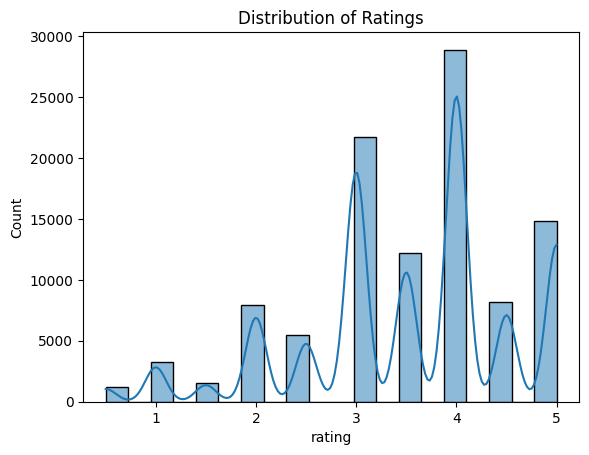

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot
import ipywidgets as widgets
from IPython.display import display

# Function to load datasets
def load_data(movies_path='movies.csv', ratings_path='ratings.csv'):
    movies = pd.read_csv(movies_path)
    ratings = pd.read_csv(ratings_path)
    return movies, ratings

def explore_data_extended(movies, ratings):
    # Basic Info
    print("Movies Dataset Info:")
    print(movies.info())
    print("\nRatings Dataset Info:")
    print(ratings.info())

    # Distribution of Ratings
    print("\nSummary Statistics for Ratings:")
    print(ratings['rating'].describe())
    print("\nDistribution of Ratings:")
    sns.histplot(ratings['rating'], bins=20, kde=True)
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

    # Unique Users and Movies
    unique_users = ratings['userId'].nunique()
    unique_movies = ratings['movieId'].nunique()
    print(f"\nUnique Users: {unique_users}")
    print(f"Unique Movies: {unique_movies}")

    # Average Rating and Total Movies at Genre Level
    print("\nAverage Rating and Total Movies at Genre Level:")
    # Split genres into individual rows
    genres_split = movies['genres'].str.split('|').explode()
    genre_movie_counts = genres_split.value_counts()
    genre_avg_ratings = (
        pd.merge(movies, ratings, on='movieId')
        .groupby('genres')['rating']
        .mean()
        .reset_index()
        .rename(columns={'rating': 'avg_rating'})
    )
    genre_summary = pd.DataFrame({
        'Genre': genre_movie_counts.index,
        'Total Movies': genre_movie_counts.values,
        'Average Rating': genre_avg_ratings.set_index('genres')['avg_rating']
    }).reset_index(drop=True)
    print(genre_summary)

    # Unique Genres Considered
    print("\nUnique Genres:")
    unique_genres = genres_split.unique()
    print(unique_genres)


# Load datasets
movies, ratings = load_data()
explore_data(movies, ratings)


In [ ]:
#Popularity-Based Recommender

def popularity_recommender(movies, ratings, genre, min_reviews, num_recommendations):
    genre_movies = movies[movies['genres'].str.contains(genre, case=False, na=False)]
    merged_data = pd.merge(genre_movies, ratings, on='movieId')
    grouped = merged_data.groupby('title').agg(
        avg_rating=('rating', 'mean'),
        num_reviews=('rating', 'count')
    ).reset_index()
    filtered = grouped[grouped['num_reviews'] >= min_reviews]
    recommendations = filtered.sort_values('avg_rating', ascending=False).head(num_recommendations)
    return recommendations


In [ ]:
#Content-Based Recommender

def content_recommender(movies, movie_title, num_recommendations):
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
    genre_matrix = vectorizer.fit_transform(movies['genres'])
    try:
        movie_idx = movies[movies['title'].str.contains(movie_title, case=False, na=False)].index[0]
    except IndexError:
        return f"Movie '{movie_title}' not found in the dataset."

    similarities = cosine_similarity(genre_matrix)
    similar_movies = sorted(list(enumerate(similarities[movie_idx])), key=lambda x: x[1], reverse=True)
    recommendations = [movies.iloc[i[0]]['title'] for i in similar_movies[1:num_recommendations+1]]
    return recommendations


In [ ]:
#Collaborative Filtering Recommender

def collaborative_recommender(ratings, user_id, num_recommendations):
    user_ids = ratings['userId'].unique()
    movie_ids = ratings['movieId'].unique()
    user_id_map = {id: idx for idx, id in enumerate(user_ids)}
    movie_id_map = {id: idx for idx, id in enumerate(movie_ids)}
    ratings['user_idx'] = ratings['userId'].map(user_id_map)
    ratings['movie_idx'] = ratings['movieId'].map(movie_id_map)

    num_users = len(user_ids)
    num_movies = len(movie_ids)

    user_input = Input(shape=(1,))
    movie_input = Input(shape=(1,))
    user_embedding = Embedding(num_users, 50)(user_input)
    movie_embedding = Embedding(num_movies, 50)(movie_input)
    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)
    dot_product = Dot(axes=1)([user_vec, movie_vec])
    model = Model([user_input, movie_input], dot_product)
    model.compile(optimizer='adam', loss='mse')

    model.fit([ratings['user_idx'], ratings['movie_idx']], ratings['rating'], epochs=10)

    user_idx = user_id_map.get(user_id)
    if user_idx is None:
        return f"User ID {user_id} not found."

    scores = model.predict([np.full(num_movies, user_idx), np.arange(num_movies)])
    top_movie_idxs = np.argsort(scores.flatten())[-num_recommendations:]
    recommendations = [movie_ids[idx] for idx in top_movie_idxs]
    return recommendations


In [ ]:
#GUI with ipywidgets

def interactive_gui(movies, ratings):
    # Widgets for Popularity-Based Recommender
    genre = widgets.Text(description="Genre:")
    min_reviews = widgets.IntText(description="Min Reviews:")
    num_rec_pop = widgets.IntText(description="Num Recommendations:")
    pop_button = widgets.Button(description="Get Popular Movies")
    pop_output = widgets.Output()

    def on_pop_click(b):
        with pop_output:
            pop_output.clear_output()
            recs = popularity_recommender(movies, ratings, genre.value, min_reviews.value, num_rec_pop.value)
            print(recs)

    pop_button.on_click(on_pop_click)

    # Widgets for Content-Based Recommender
    movie_title = widgets.Text(description="Movie Title:")
    num_rec_content = widgets.IntText(description="Num Recommendations:")
    content_button = widgets.Button(description="Get Similar Movies")
    content_output = widgets.Output()

    def on_content_click(b):
        with content_output:
            content_output.clear_output()
            recs = content_recommender(movies, movie_title.value, num_rec_content.value)
            print(recs)

    content_button.on_click(on_content_click)

    # Display GUI
    display(widgets.VBox([
        widgets.HTML("<h2>Popularity-Based Recommender</h2>"),
        genre, min_reviews, num_rec_pop, pop_button, pop_output,
        widgets.HTML("<h2>Content-Based Recommender</h2>"),
        movie_title, num_rec_content, content_button, content_output,
    ]))


# Launch the GUI
interactive_gui(movies, ratings)


In [ ]:
def interactive_gui_collaborative(ratings):
    # Widgets for Collaborative Filtering Recommender
    user_id = widgets.IntText(description="User ID:")
    num_rec_collab = widgets.IntText(description="Num Recommendations:")
    collab_button = widgets.Button(description="Get Recommendations")
    collab_output = widgets.Output()

    # Function to trigger recommendations on button click
    def on_collab_click(b):
        with collab_output:
            collab_output.clear_output()  # Clear previous outputs
            try:
                recommendations = collaborative_recommender(ratings, user_id.value, num_rec_collab.value)
                if isinstance(recommendations, str):  # Handle error messages
                    print(recommendations)
                else:
                    print("Top Recommended Movies:")
                    for i, movie_id in enumerate(recommendations, start=1):
                        print(f"{i}. Movie ID: {movie_id}")
            except Exception as e:
                print(f"Error: {e}")

    collab_button.on_click(on_collab_click)

    # Display the GUI for collaborative filtering
    display(widgets.VBox([
        widgets.HTML("<h2>Collaborative Filtering Recommender</h2>"),
        user_id, num_rec_collab, collab_button, collab_output,
    ]))

# Call the GUI function
interactive_gui_collaborative(ratings)
